In [ ]:
!pip install xgboost

In [2]:
# Importing important libraries for performing TimeSeries Analysis and fitting the model

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [3]:
# Loading the dataset from localhost

df = pd.read_csv('C:/Users/Asus/OneDrive/Documents/Buckman test/shipment_data.csv')


#Extracting date and movement features in order to make the dataset a TimeSeries dataset

df = df[['Delivery Date', 'Movement']]
df = df.set_index('Delivery Date')

In [4]:
# Converting the object type of 'Delivery Date' to datetime type
df.index = pd.to_datetime(df.index)

In [5]:
# Grouping all different records for same date and summing their movement value
df = df.sort_values('Delivery Date').groupby('Delivery Date').sum('Movement')

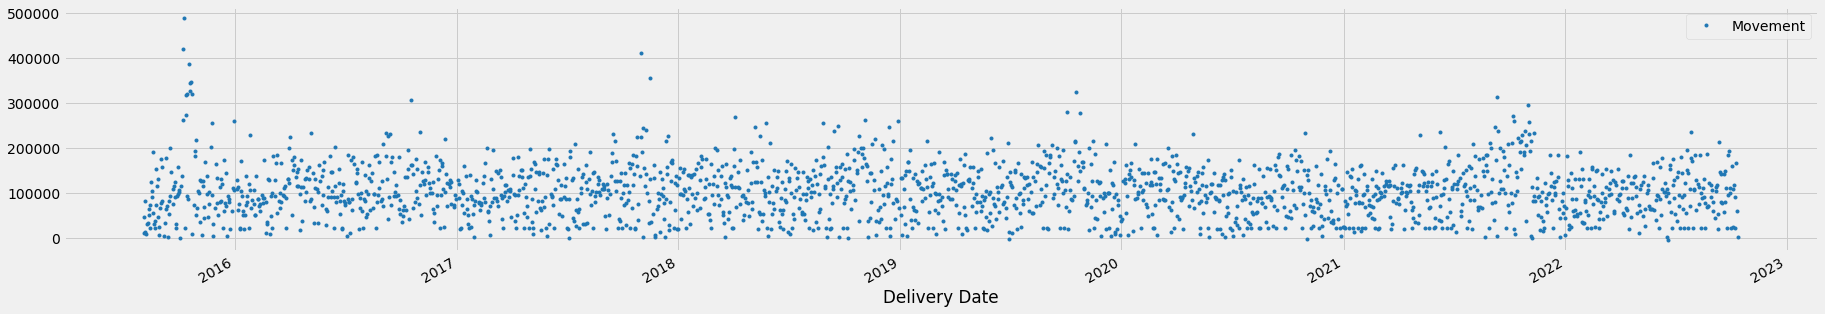

In [6]:
df.plot(style = '.',
        figsize=(28, 5),
        color = color_pal[0])
plt.show()

<AxesSubplot:ylabel='Frequency'>

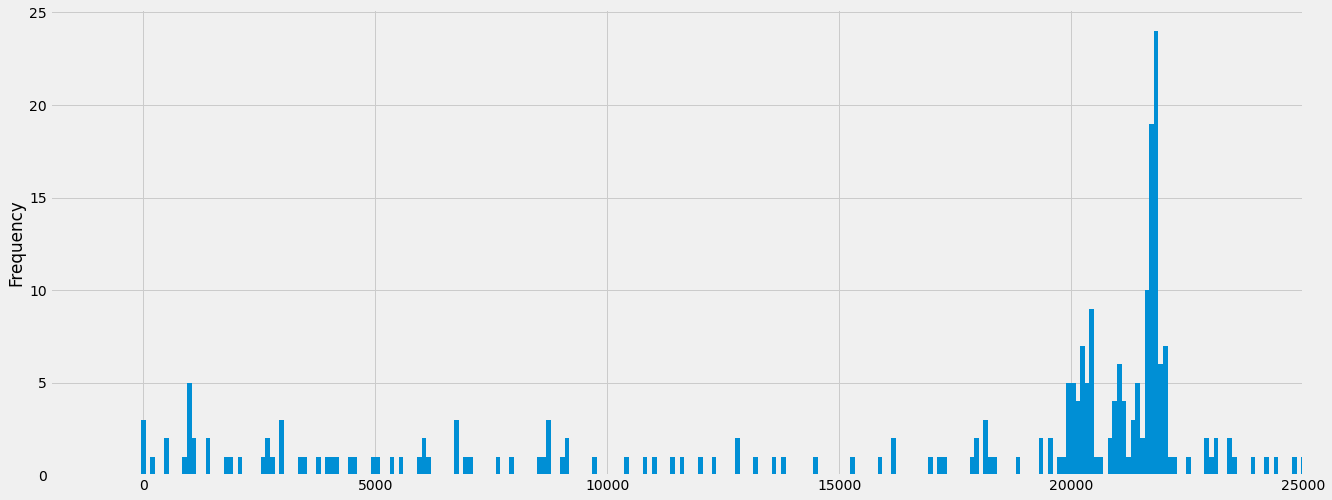

In [7]:
plt.xlim(-2000,25000)
df['Movement'].plot(kind='hist', bins=5000, figsize=(20,8))

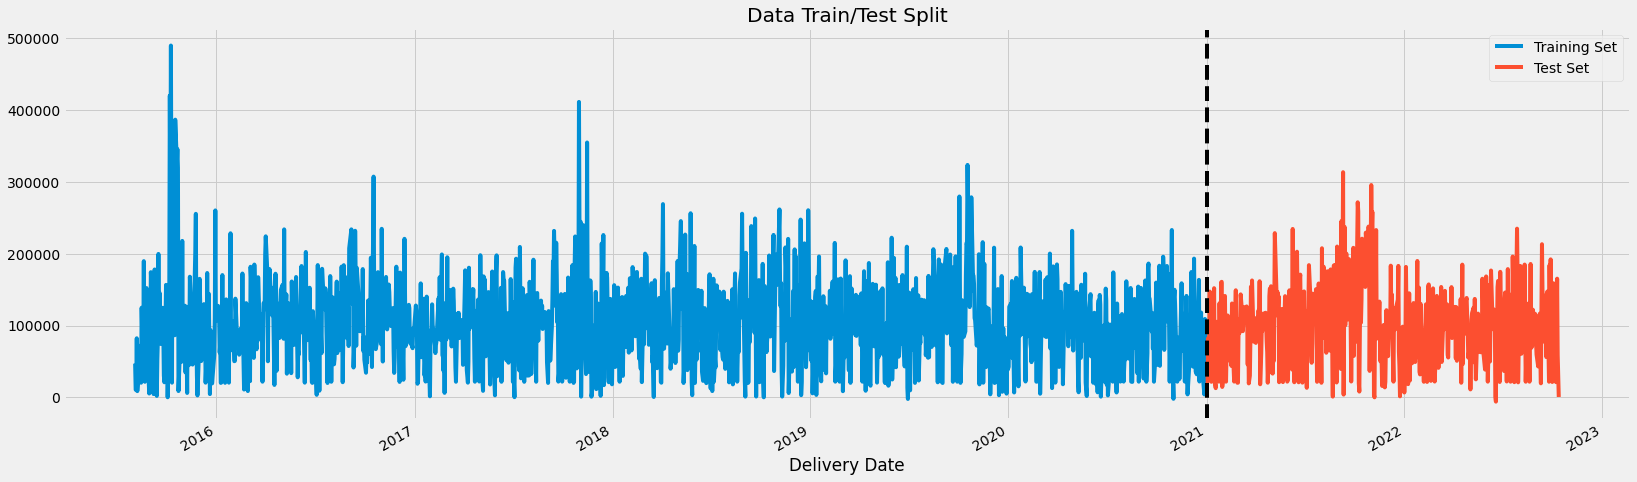

In [8]:
# Considering data before 2021 for training purpose and rest for testing/validation

train = df.loc[df.index < '01-01-2021']
test = df.loc[df.index >= '01-01-2021']

# Plotting training and test set
fig, ax = plt.subplots(figsize=(25,8))
train.plot(ax = ax, label = 'Training Set', title= 'Data Train/Test Split')
test.plot(ax = ax, label = 'Test Set')
ax.axvline('01-01-2021', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

#### Time Series Cross Validation

In [9]:
print('Train set size: ',train.shape)
print('Test set size: ',test.shape)

Train set size:  (1565, 1)
Test set size:  (524, 1)


In [10]:
df.shape

(2089, 1)

In [11]:
from sklearn.model_selection import TimeSeriesSplit

In [12]:
tss = TimeSeriesSplit(n_splits=5, test_size = df.shape[0]//6)
df = df.sort_index()

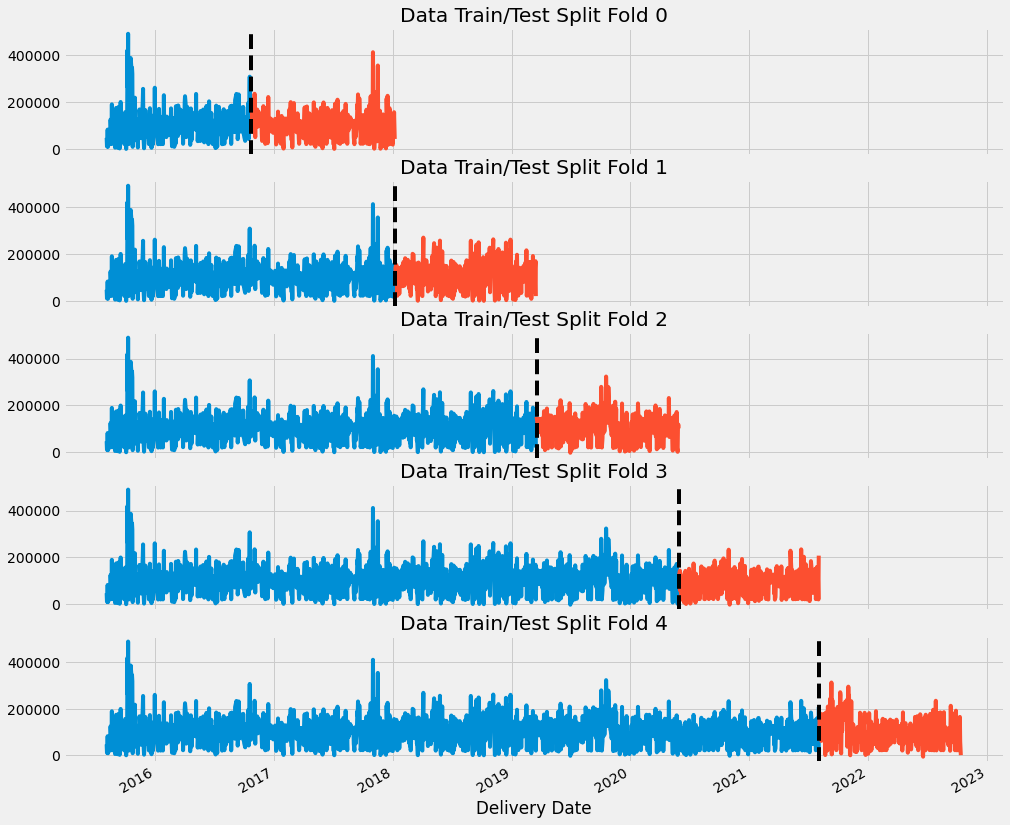

In [14]:
fig, axs = plt.subplots(5, 1, figsize = (15,15), sharex = True)
fold = 0
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]

    train['Movement'].plot(ax = axs[fold],
                           label = 'Training Set',
                           title = f'Data Train/Test Split Fold {fold}')
    test['Movement'].plot(ax = axs[fold],
                          label='Test Set')
    axs[fold].axvline(test.index.min(), color = 'black', ls='--')
    fold += 1 
plt.show()

In [15]:
def create_features(df):
    df = df.copy()
    df['hour'] = df.index.hour
    df['day_of_week'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['day_of_year'] = df.index.dayofyear
    df['day_of_month'] = df.index.day
    # df['week_of_year'] = df.index.isocalendar().week
    return df

#### Grouping data month wise

In [62]:
grouped_by_month = pd.DataFrame(df.groupby(['year','month']).sum('Movement')['Movement'])
grouped_by_month

Movement
year month             
2015 8      1691061.302
     9      2326050.837
     10     5255535.531
     11     2125971.081
     12     2314267.208
...                 ...
2022 6      2555486.790
     7      2621569.758
     8      2549889.961
     9      2486366.078
     10      764999.082

[87 rows x 1 columns]

#### Adding Lag to the Dataset
##### Lag is basically comparing the timeseries data with itself but by shift its value.
##### Lag is a delay that moves to and fro in timeseries data in order to draw similarity in the dataset.

In [16]:
def add_lags(df):
    target_map = df['Movement'].to_dict()
    df['lag1'] = (df.index - pd.Timedelta('364 days')).map(target_map)
    df['lag2'] = (df.index - pd.Timedelta('728 days')).map(target_map)
    df['lag3'] = (df.index - pd.Timedelta('1092 days')).map(target_map)
    return df


In [17]:
df = add_lags(df)

In [18]:
tss = TimeSeriesSplit(n_splits=5, test_size = df.shape[0]//6)
df = df.sort_index()

fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    
    train = create_features(train)
    test = create_features(test)
    features = ['hour','day_of_week','quarter','month','year','day_of_year','day_of_month','lag1','lag2','lag3']
    target = ['Movement']
    
    X_train = train[features]
    y_train = train[target]
    
    X_test = test[features]
    y_test = test[target]
    
    # Training the timeseries data with a XGBRegressor model
    
    reg = xgb.XGBRegressor(base_score = 0.5, 
                           booster = 'gbtree',
                           n_estimators = 1000,
                           early_stopping_rounds = 50,
                           objective = 'reg:linear',
                           max_depth = 3,
                           learning_rate = 0.01)
    
    reg.fit(X_train, y_train, eval_set=[(X_train, y_train),(X_test, y_test)],
            verbose = 100)
    
    
    # Making predictions once the model is fitted to a certain fold of training data
    
    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)

[03:11:58] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:126796.81711	validation_1-rmse:116851.99557
[100]	validation_0-rmse:70094.71125	validation_1-rmse:65514.77083
[200]	validation_0-rmse:54682.19712	validation_1-rmse:56714.01866
[295]	validation_0-rmse:50404.94237	validation_1-rmse:56675.58470
[03:11:58] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:121938.80833	validation_1-rmse:120054.80113
[100]	validation_0-rmse:67485.35519	validation_1-rmse:65259.58269
[200]	validation_0-rmse:54662.04004	validation_1-rmse:51406.19424
[300]	validation_0-rmse:51007.31248	validation_1-rmse:48640.25796
[400]	vali

In [44]:
X_train

,hour,day_of_week,quarter,month,year,day_of_year,day_of_month,lag1,lag2,lag3
Delivery Date,,,,,,,,,,
2015-08-04,0,1,3,8,2015,216,4,NaN,NaN,NaN
2015-08-05,0,2,3,8,2015,217,5,NaN,NaN,NaN
2015-08-06,0,3,3,8,2015,218,6,NaN,NaN,NaN
2015-08-07,0,4,3,8,2015,219,7,NaN,NaN,NaN
2015-08-08,0,5,3,8,2015,220,8,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2021-07-28,0,2,3,7,2021,209,28,116010.011,87060.086,134370.707
2021-07-29,0,3,3,7,2021,210,29,30987.614,120230.713,109481.310
2021-07-30,0,4,3,7,2021,211,30,77120.531,58530.311,126551.051


In [19]:
# Cross-verifying that each feature has appropriate type
print(train.dtypes)

Movement        float64
lag1            float64
lag2            float64
lag3            float64
hour              int64
day_of_week       int64
quarter           int64
month             int64
year              int64
day_of_year       int64
day_of_month      int64
dtype: object


In [20]:
print(f'Mean score across folds {np.mean(scores):0.4f}')

Mean score across folds 47306.0197


## Predicting the future

Once the model is ready, now its time to forecast future movement values.
Creating a dataframe with next 10 months future dates
Note the value of Movement column is NaN currently. We will predict the movement value using same xgbregressor instance. 

In [21]:
df = create_features(df)

features = ['hour','day_of_week','quarter','month','year','day_of_year','day_of_month','lag1','lag2','lag3']
target = ['Movement']

X_all = df[features]
y_all = df[target]


reg = xgb.XGBRegressor(base_score = 0.5, 
                        booster = 'gbtree',
                        n_estimators = 500,
                        objective = 'reg:linear',
                        max_depth = 3,
                        learning_rate = 0.01)

reg.fit(X_all, y_all,
        eval_set = [(X_all, y_all)],
        verbose = 100)

[03:12:00] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:117245.69583
[100]	validation_0-rmse:62558.28375
[200]	validation_0-rmse:49973.06829
[300]	validation_0-rmse:47153.00715
[400]	validation_0-rmse:45977.53204
[499]	validation_0-rmse:45310.69046


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.01, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=3, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=500, n_jobs=0,
             num_parallel_tree=1, objective='reg:linear', predictor='auto', ...)

In [22]:
df.index.max()

Timestamp('2022-10-13 00:00:00')

In [23]:
future = pd.date_range('2022-10-13', '2023-08-01', freq = '1d')
future_df = pd.DataFrame(index = future)
future_df['isFuture'] = True  # True if date is a future date
df['isFuture'] = False        # False otherwise
df_and_future = pd.concat([df, future_df])  # Merging dataframes
df_and_future = create_features(df_and_future)
df_and_future = add_lags(df_and_future)

In [24]:
future_w_features = df_and_future.query('isFuture').copy()

In [25]:
future_w_features

,Movement,lag1,lag2,lag3,hour,day_of_week,quarter,month,year,day_of_year,day_of_month,isFuture
2022-10-13,NaN,136112.040,66070.532,213349.781,0,3,4,10,2022,286,13,True
2022-10-14,NaN,220981.302,148838.418,323771.911,0,4,4,10,2022,287,14,True
2022-10-15,NaN,NaN,NaN,NaN,0,5,4,10,2022,288,15,True
2022-10-16,NaN,NaN,NaN,NaN,0,6,4,10,2022,289,16,True
2022-10-17,NaN,191162.902,113122.208,158572.748,0,0,4,10,2022,290,17,True
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-07-28,NaN,169902.025,156256.098,77120.531,0,4,3,7,2023,209,28,True
2023-07-29,NaN,20865.232,NaN,21863.134,0,5,3,7,2023,210,29,True
2023-07-30,NaN,NaN,20239.275,NaN,0,6,3,7,2023,211,30,True
2023-07-31,NaN,107558.004,207648.816,57851.131,0,0,3,7,2023,212,31,True


### FORECASTING

In [26]:
future_w_features['pred'] = reg.predict(future_w_features[features])

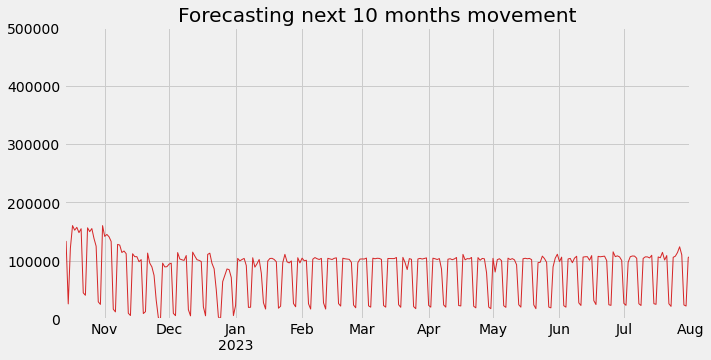

In [43]:
future_w_features['pred'].plot(figsize=(10,5),
                               ylim=(0, 500000),
                               color = color_pal[3],
                               ms = 1,
                               lw = 1,
                               title = 'Forecasting next 10 months movement')
plt.show()

In [33]:
forecasting = pd.DataFrame(future_w_features.iloc[:,-1])

In [34]:
# Dataframe contains the prediction value for next 10 months
forecasting

,pred
2022-10-13,126834.101562
2022-10-14,133327.343750
2022-10-15,26054.714844
2022-10-16,121759.453125
2022-10-17,160334.296875
...,...
2023-07-28,110074.500000
2023-07-29,24277.916016
2023-07-30,22409.523438
2023-07-31,105263.656250


In [38]:
forecasting['month'] =forecasting.index.month

In [40]:
forecasting.groupby('month').sum('pred')

,pred
month,
1,2.381654e+06
2,2.233420e+06
3,2.534990e+06
4,2.249667e+06
5,2.491500e+06
6,2.519009e+06
7,2.507388e+06
8,1.085425e+05
10,2.207452e+06
